# Question 2: Classification
## Machine Learning Foundations with Python 
### 90-803 - Spring 2024
### Sprint Team #17
### Name:  Jewel Yoko Kentilitisca, Hannah Ngyugen, Quintessa Guegerich


### Can we classify counties in historically "Warm Temperature", "Moderate Temperature", and "Cold Temperature" States as Not Outliers and Outliers ?
   -Based on our linear regression  (using RANSAC) we were able to classify counties as outliers and not outliers. In this case we want to apply that to regions who are within the same annual temperature average. 
   Target variable: The target variable for this classification problem is to classify outlier and not outlier counties. 
    (a) 1 - Outliers
    (b) 0 - Not outliersNegative impact: Low temperatures anomalies lead to a decrease/no change in property prices


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.preprocessing import OneHotEncoder
import time

from yellowbrick.target import ClassBalance
from imblearn.over_sampling import SMOTE

# Importing preprocessing and modeling libraries
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import tree

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

### Preprocessing the Data

In [2]:
#Dictionary for state codes for us to be able to merge another dataset for longitude and latitude
state_codes = {
    'AL': '01',
    'AK': '02',
    'AZ': '04',
    'AR': '05',
    'CA': '06',
    'CO': '08',
    'CT': '09',
    'DE': '10',
    'FL': '12',
    'GA': '13',
    'HI': '15',
    'ID': '16',
    'IL': '17',
    'IN': '18',
    'IA': '19',
    'KS': '20',
    'KY': '21',
    'LA': '22',
    'ME': '23',
    'MD': '24',
    'MA': '25',
    'MI': '26',
    'MN': '27',
    'MS': '28',
    'MO': '29',
    'MT': '30',
    'NE': '31',
    'NV': '32',
    'NH': '33',
    'NJ': '34',
    'NM': '35',
    'NY': '36',
    'NC': '37',
    'ND': '38',
    'OH': '39',
    'OK': '40',
    'OR': '41',
    'PA': '42',
    'RI': '44',
    'SC': '45',
    'SD': '46',
    'TN': '47',
    'TX': '48',
    'UT': '49',
    'VT': '50',
    'VA': '51',
    'WA': '53',
    'WV': '54',
    'WI': '55',
    'WY': '56'
}


In [3]:
#Reading the CSVs
merged_data = pd.read_csv('all_data.csv')
merged_data.head()
merged_data['StateFP'] = merged_data['StateAbbrv'].map(state_codes)
us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merged_data.merge(us_counties, left_on=['RegionName', 'StateFP'], right_on=['NAMELSAD', 'STATEFP'])

merged_data.head()

#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']
merged_data[columns_to_float] = merged_data[columns_to_float].astype(float)

#Changing variable name
filtered_states = merged_data
filtered_states.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)

### *Data Exploration*

In [4]:
filtered_states_sorted = filtered_states.sort_values(by='Anomaly (1901-2000 base period)', ascending=False)

filtered_states_sorted.describe()

,Unnamed: 0,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON
count,579894.000000,579894.000000,579894.000000,579894.000000,5.798940e+05,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,579894.000000,5.798940e+05,5.798940e+05,579894.000000,579894.000000
mean,298642.184163,2010.712761,6.434317,94103.848741,2.851340e+05,55.702485,1.385632,54.317547,0.891515,4.955709,22.500000,177.251586,260.126543,72.512364,37.364843,2.338742e+09,1.819740e+08,37.986718,-89.613755
std,172104.966217,5.361191,3.466285,64177.827177,2.108634e+05,17.135498,3.388082,17.099949,0.365064,1.232351,7.500006,36.994047,36.813915,8.549974,29.181675,3.703393e+09,5.523955e+08,4.615860,12.635366
min,0.000000,2000.000000,1.000000,6109.396309,5.947229e+04,-5.200000,-22.200000,1.800000,0.180000,2.890000,15.000000,60.300000,124.000000,42.300000,1.300000,5.868388e+07,9.251200e+04,25.586120,-124.210929
25%,149711.250000,2007.000000,3.000000,52879.469613,1.884248e+05,42.800000,-0.700000,41.300000,0.540000,3.980000,15.000000,150.900000,237.700000,67.100000,7.700000,1.055922e+09,1.047176e+07,34.763109,-94.888456
50%,298870.500000,2011.000000,6.000000,77205.031646,2.347503e+05,57.200000,1.300000,55.500000,0.910000,4.650000,22.500000,179.800000,262.500000,74.800000,32.450000,1.479110e+09,2.694270e+07,38.423084,-86.034263
75%,447717.750000,2015.000000,9.000000,115764.095664,3.139183e+05,70.000000,3.400000,68.800000,1.220000,5.960000,30.000000,204.400000,286.100000,80.300000,65.500000,2.206699e+09,8.116171e+07,41.355319,-81.400955
max,596365.000000,2019.000000,12.000000,915009.312632,5.178158e+06,96.200000,19.800000,91.700000,1.510000,8.550000,30.000000,254.800000,347.300000,83.500000,82.900000,5.197631e+10,1.405367e+10,48.842653,-68.666616


In [5]:
filtered_states['Average Temperature Value'].describe()

count    579894.000000
mean         55.702485
std          17.135498
min          -5.200000
25%          42.800000
50%          57.200000
75%          70.000000
max          96.200000
Name: Average Temperature Value, dtype: float64

In [6]:
filtered_states['Anomaly (1901-2000 base period)'].describe()

count    579894.000000
mean          1.385632
std           3.388082
min         -22.200000
25%          -0.700000
50%           1.300000
75%           3.400000
max          19.800000
Name: Anomaly (1901-2000 base period), dtype: float64

We see that there are significant regional temperature differences within these particular states, meaning that it might be useful dividing states up regionally based on similarities in average temperatures. 

Comparing an area’s recent temperature to its long-term average can tell how warm or how cool the area is compared to usual. Temperature anomalies also give us a frame of reference to better compare location. So for our data we will also be labeling areas based on regional similarities. 

So it looks like after scaling our data, we would want to divide our data into 3 regions. By doing so we are able to find outliers for states that are grouped together based on similarities in average temperatures. 

Another option is to classify based on domain knowledge. 
Since we know whih specific regions have the same annual temperature in terms of climate similarities we can divide things up regionally.
I divided based on average annual temperature ranks from the NOAA data. 
![Screenshot 2024-04-16 at 8.47.09 AM.png](<attachment:Screenshot 2024-04-16 at 8.47.09 AM.png>) 
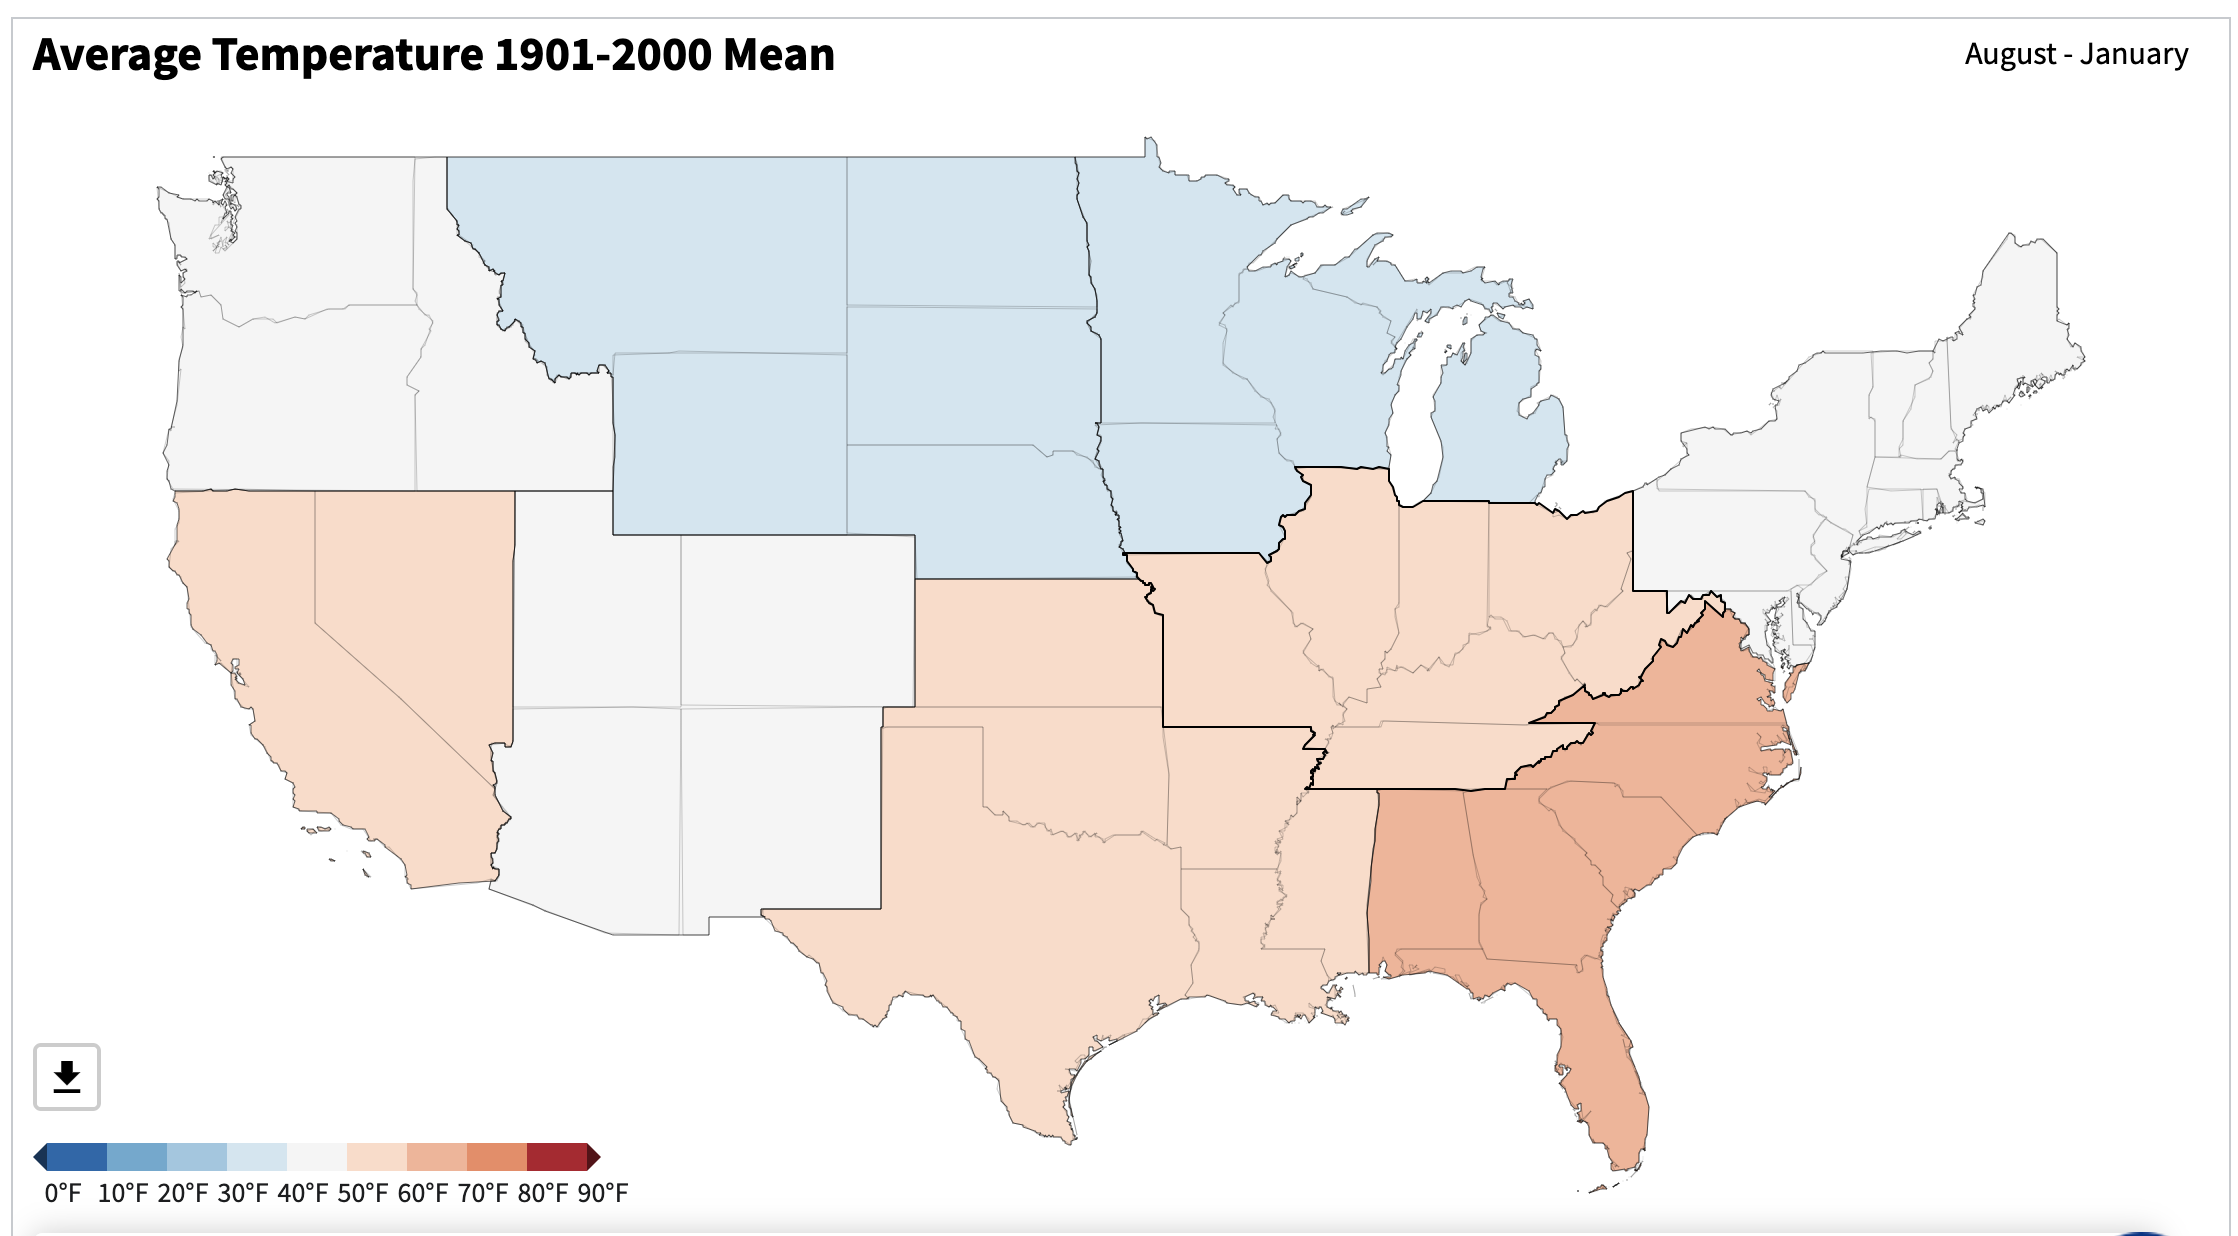

---
### Merging with Linear Regression Outlier Data


In [7]:
#merging with outlier data 
outliers = pd.read_csv('all_data_w_outliers.csv')

data = pd.merge(filtered_states, outliers[['Is_Outlier']], left_index=True, right_index=True)

/var/folders/6c/t8_sl0r155q97klcrfwnkw7h0000gn/T/ipykernel_43514/3502611620.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  outliers = pd.read_csv('all_data_w_outliers.csv')


In [8]:
# # Define temperature categories
# def categorize_temperature(temperature):
#     if temperature > 65:
#         return 'Warm'
#     elif temperature > 55:
#         return 'Moderate'
#     elif temperature > 45:
#         return 'Cold'

temperature_regions = {
    'Warm all year round': ['HI', 'FL', 'LA', 'AZ', 'TX', 'MS', 'AL', 'GA', 'SC', 'CA'],
    'Moderate': ['OK', 'AR', 'NC', 'TN', 'NV', 'KY', 'VA', 'MO', 'KS', 'MD', 'DE', 'WV', 'NM', 'NJ', 'IN', 'IL', 'OR', 
                 'OH', 'WA', 'NE', 'PA', 'UT', 'RI', 'CT', 'NY', 'MA', 'IA', 'MI', 'CO'],
    'Cold': ['ID', 'SD', 'WI', 'NH', 'MT', 'VT', 'WY', 'ME', 'MN', 'ND', 'AK']
}

# Add a new column 'Temperature_Category' to data based on state abbreviations
data['Temperature_Category'] = data['StateAbbrv'].map({state: category for category, states in temperature_regions.items() for state in states})


print(data.head())

# Initialize 
label_encoder = LabelEncoder()

# Fit and transform the 'Temperature_Category' column
data['Temperature_Category_Label'] = label_encoder.fit_transform(data['Temperature_Category'])

data.drop(columns=['Temperature_Category'], inplace=True)

# DataFrame
data.head()

#0 = Cold, 1=Moderate, 2= Warm

   Unnamed: 0        Date  Year  Month          RegionName State  \
0           0  2000-01-31  2000      1  Los Angeles County    CA   
1           1  2000-01-31  2000      1  Los Angeles County    CA   
2        1566  2000-02-29  2000      2  Los Angeles County    CA   
3        1567  2000-02-29  2000      2  Los Angeles County    CA   
4        3136  2000-03-31  2000      3  Los Angeles County    CA   

   Bottom-Tier Average Home Value Estimate  \
0                            122826.545216   
1                            122826.545216   
2                            122977.776411   
3                            122977.776411   
4                            123487.708531   

   Top-Tier Average Home Value Estimate  Average Temperature Value  \
0                         400192.738911                       52.3   
1                         400192.738911                       52.3   
2                         400660.415894                       50.6   
3                         400660.4

,Unnamed: 0,Date,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Is_Outlier,Temperature_Category_Label
0,0,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
1,1,2000-01-31,2000,1,Los Angeles County,CA,122826.545216,400192.738911,52.3,4.5,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
2,1566,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
3,1567,2000-02-29,2000,2,Los Angeles County,CA,122977.776411,400660.415894,50.6,1.1,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2
4,3136,2000-03-31,2000,3,Los Angeles County,CA,123487.708531,402315.707957,53.8,1.7,...,None,None,A,1.051599e+10,1.785003e+09,34.196398,-118.261862,"MULTIPOLYGON (((-118.67820 33.03973, -118.6756...",True,2


### Figuring out how to make this into a classification problem

1. Make temperature into a multiclass of 1 = Low, 2 = Medium, and 3 - High in terms of temperature risk based on anomalies [did not go with this option]
2. Look at the ratio changes between purchase price, bottom tier average home value estimate, and top tier average home value estimate, grouping by month/year.
3. Include temperature anomaly data into one combined value reflecting the impact on housing prices, trying to calculate by putting weights?

    -Normalizing the Temperature Anomaly Data: Ensure that the temperature anomaly data is on a similar scale as the housing price data. This might involve scaling or normalization.

    -Define Weights: Assign weights to the housing price change and temperature anomaly change based on their relative importance in influencing housing prices. These weights can be subjective.

    -Calculate Combined Impact: Multiply the percentage change in housing prices and the normalized temperature anomaly data by their respective weights, and then add them together to get a combined impact value.

### Intention: Look if positive values may indicate that higher temperature anomalies are associated with a higher likelihood of a certain class (higher percentage change in housing prices, both for bottom tier and top tier), while negative values may indicate the opposite.

### Standardizing Temperature Anomaly 

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Column Names we want to scale
columns_to_scale = ['Anomaly (1901-2000 base period)', 'Bottom-Tier Average Home Value Estimate', 'Top-Tier Average Home Value Estimate', 'Average Temperature Value']

# Fit the scaler to the specified columns
scaler.fit(data[columns_to_scale])


MinMaxScaler()

#### Dropping unnecessary columns 

In [10]:
#Keep Is_Outlier 
#Keeping these columns and converting to float
columns_to_float = ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Is_Outlier']
data[columns_to_float] = data[columns_to_float].astype(float)

# Get column names with object data types
object_columns = data.select_dtypes(include=['object']).columns

# Drop the columns with object or geometry data types
data = data.drop(object_columns, axis=1)
data = data.drop(columns='geometry', axis=1)
data.drop(columns='Unnamed: 0', inplace=True)


In [11]:
#Checking if there's nulls
# your code here
pd.concat({"Number missing values":data.isnull().sum()
            , "Percentage of missing values":data.isnull().sum()*100/data.shape[0]}
            , axis=1)

nan_rows = data[data['Is_Outlier'].isna()]
nan_rows.sample(20)

data.dropna(subset=['Is_Outlier'], inplace=True)


### Now I think we want to divide our data into specific regions and clarify which counties are outliers in terms of temperature anomalies thing what there temperature is

In [12]:
# Filter the DataFrame for warm states
warm_states = data[data['Temperature_Category_Label'] == 2]

# Filter the DataFrame for moderate states
moderate_states = data[data['Temperature_Category_Label'] == 1]

# Filter the DataFrame for cold states
cold_states = data[data['Temperature_Category_Label'] == 0]

### Looking at distributions of Temperature and Housing Prices

In [13]:
warm_states['Anomaly (1901-2000 base period)'].describe()

count    134050.000000
mean          1.252179
std           2.842373
min         -10.100000
25%          -0.500000
50%           1.200000
75%           3.000000
max          14.000000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Warm States')

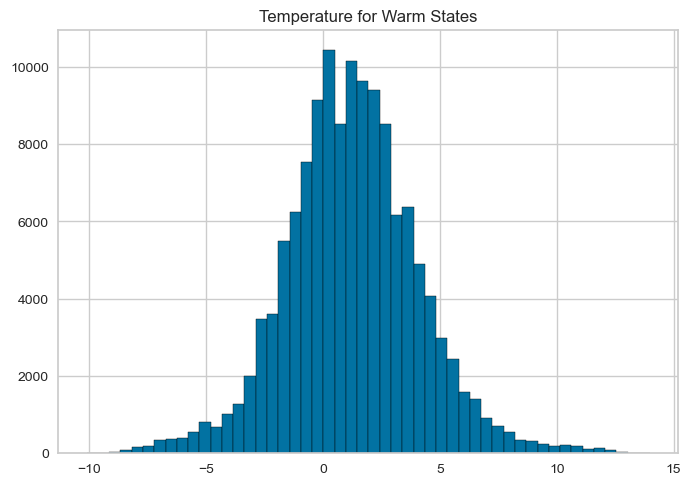

In [14]:
plt.hist(warm_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Warm States')

Text(0.5, 1.0, 'Purchase Price for Warm States')

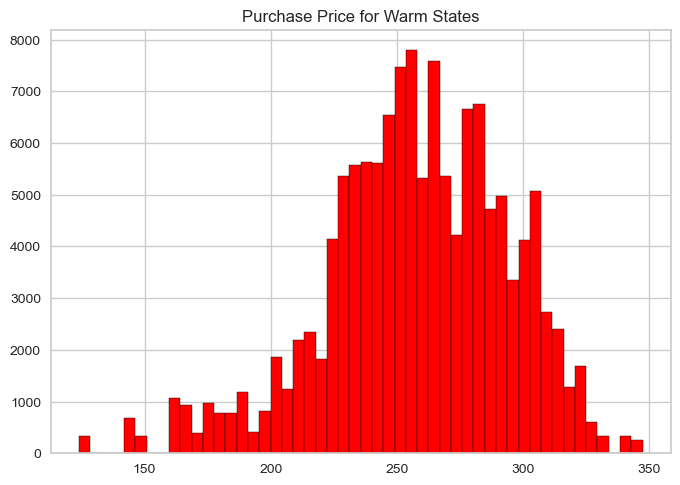

In [15]:
plt.hist(warm_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Red') 
plt.title('Purchase Price for Warm States')

In [16]:
warm_states['Purchase Price ($thou)'].describe()


count    134050.000000
mean        257.596731
std          36.667111
min         124.000000
25%         236.000000
50%         258.700000
75%         283.900000
max         347.300000
Name: Purchase Price ($thou), dtype: float64

In [17]:
moderate_states['Anomaly (1901-2000 base period)'].describe()

count    327426.000000
mean          1.380002
std           3.438513
min         -14.900000
25%          -0.700000
50%           1.300000
75%           3.400000
max          17.900000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Moderate States')

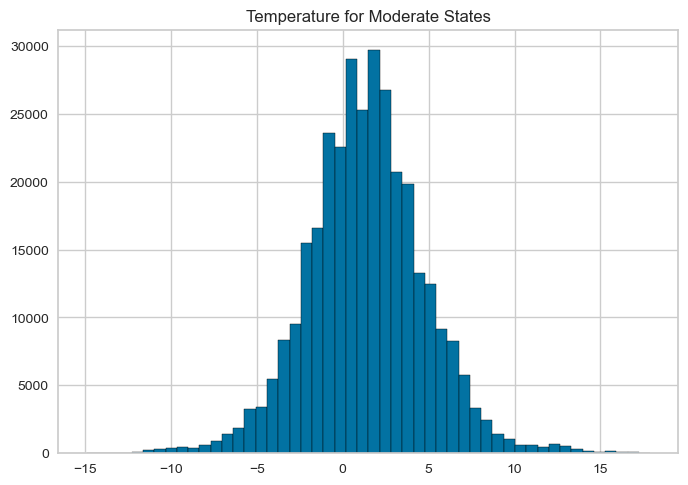

In [18]:
plt.hist(moderate_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Moderate States')

Text(0.5, 1.0, 'Purchase Price Moderate States')

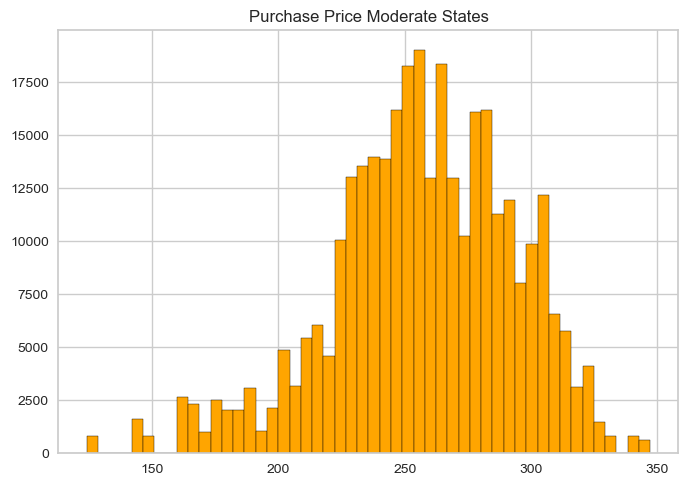

In [19]:
plt.hist(moderate_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Orange') 
plt.title('Purchase Price Moderate States')

In [20]:
moderate_states['Purchase Price ($thou)'].describe()

count    327426.000000
mean        257.035542
std          36.844478
min         124.000000
25%         235.400000
50%         257.500000
75%         283.200000
max         347.300000
Name: Purchase Price ($thou), dtype: float64

In [21]:
cold_states['Anomaly (1901-2000 base period)'].describe()

count    42876.000000
mean         1.688045
std          4.048026
min        -22.200000
25%         -0.600000
50%          1.500000
75%          3.900000
max         19.800000
Name: Anomaly (1901-2000 base period), dtype: float64

Text(0.5, 1.0, 'Temperature for Cold States')

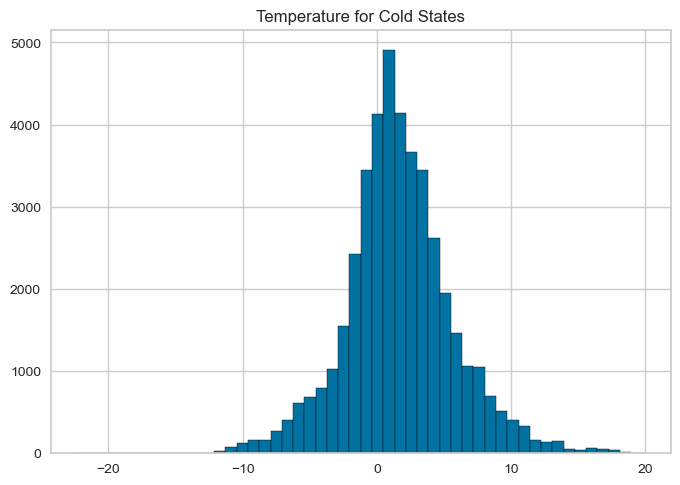

In [22]:
plt.hist(cold_states['Anomaly (1901-2000 base period)'], bins=50, edgecolor='black') 
plt.title('Temperature for Cold States')

Text(0.5, 1.0, 'Purchase Price Cold States')

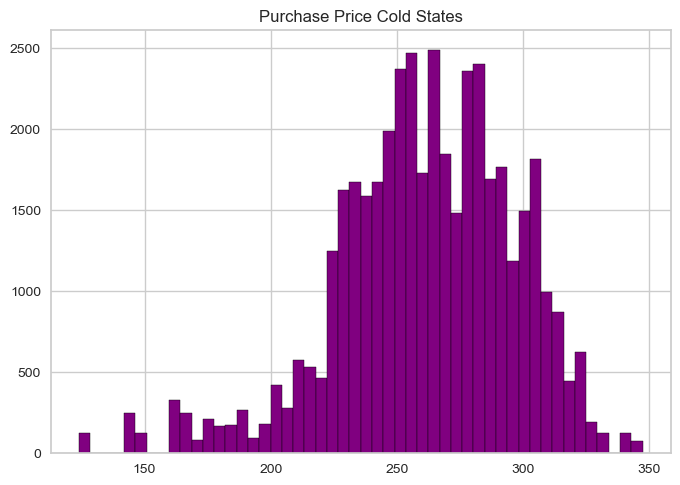

In [23]:
plt.hist(cold_states['Purchase Price ($thou)'], bins=50, edgecolor='black', color= 'Purple') 
plt.title('Purchase Price Cold States')

In [24]:
cold_states['Purchase Price ($thou)'].describe()

count    42876.000000
mean       261.246530
std         35.930104
min        124.000000
25%        240.200000
50%        262.900000
75%        286.100000
max        347.300000
Name: Purchase Price ($thou), dtype: float64

In [25]:
warm_states.sort_values(by='Purchase Price ($thou)', ascending=False)

,Year,Month,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),ALAND,AWATER,INTPTLAT,INTPTLON,Is_Outlier,Temperature_Category_Label
91952,2008,1,74406.172542,230239.818314,43.2,-1.1,44.3,0.41,5.65,15,141.3,347.3,49.5,6.5,1.810413e+09,1.518174e+08,33.899246,-81.266118,0.0,2
297266,2008,1,82296.187750,227858.379000,40.6,-1.3,41.9,0.41,5.65,15,141.3,347.3,49.5,6.5,7.312146e+08,8.448220e+06,34.128526,-83.203737,0.0,2
410390,2008,1,115169.285087,266104.715420,49.7,-1.4,51.1,0.41,5.65,15,141.3,347.3,49.5,6.5,1.678653e+09,1.121754e+08,30.440419,-90.727474,0.0,2
51194,2008,1,115109.111197,346800.464058,59.8,1.5,58.3,0.41,5.65,15,141.3,347.3,49.5,6.5,2.851877e+09,8.581195e+08,29.057769,-81.161792,1.0,2
301888,2008,1,106253.541180,344427.318681,48.2,-0.6,48.8,0.41,5.65,15,141.3,347.3,49.5,6.5,1.696858e+09,1.202287e+08,32.430590,-81.021627,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419426,2011,11,95387.590109,335675.571915,57.9,2.7,55.2,0.63,4.32,15,88.2,124.0,73.9,4.7,2.857618e+09,1.023176e+07,30.059953,-99.353339,1.0,2
346166,2011,11,19849.928498,104295.198544,55.9,1.4,54.5,0.63,4.32,15,88.2,124.0,73.9,4.7,9.304781e+08,8.740237e+06,32.665847,-83.425879,1.0,2
62880,2011,11,121291.046583,302315.022130,51.7,-1.7,53.4,0.63,4.32,15,88.2,124.0,73.9,4.7,2.128287e+09,2.186152e+08,38.267226,-121.939594,0.0,2
362348,2011,11,177892.151898,477550.570057,46.3,-0.7,47.0,0.63,4.32,15,88.2,124.0,73.9,4.7,9.241141e+09,1.254150e+09,40.706655,-123.926176,1.0,2


---

## *Classification Models and Hyperparameter Tuning for Outliers* 

 1. Naive Bayes
 2. Logistic Regression
 3. KNN
 4. Random Forests Classifier
 5. Decision Tree Classifier
 6. Adaboost 
 7. New Model



## Train/Test Splitting Data for *Warm States*

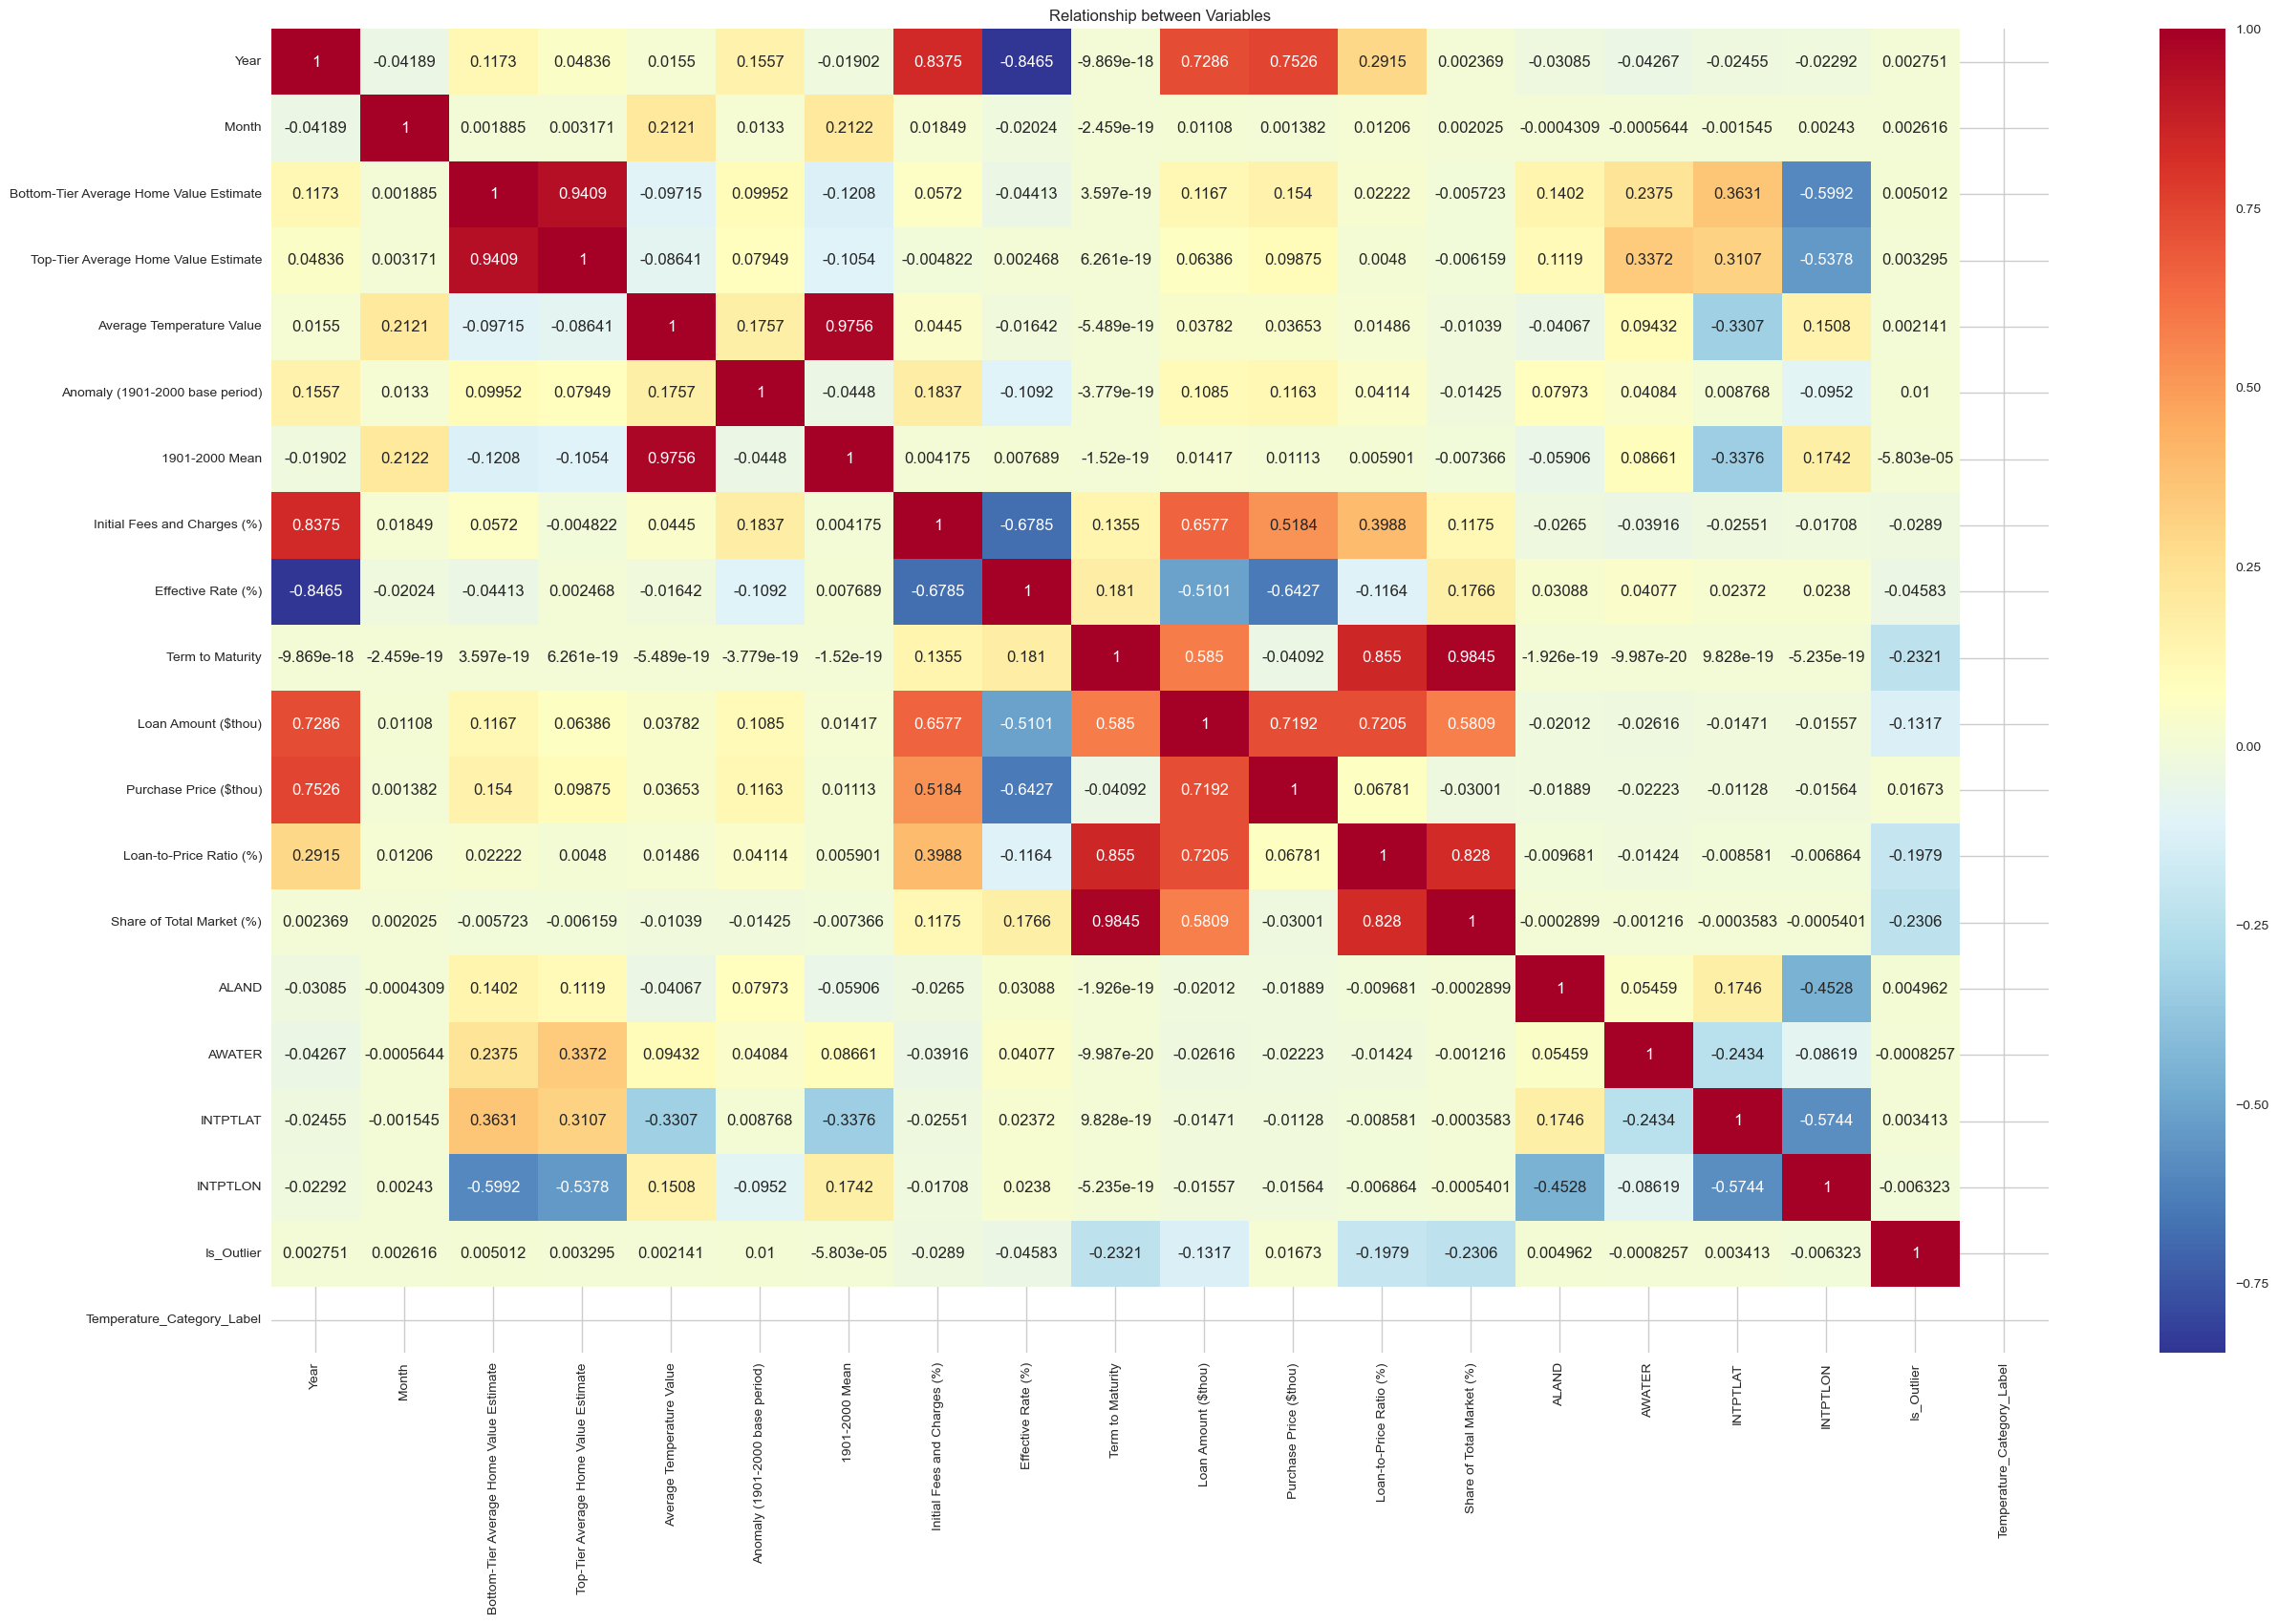

In [26]:
corr_matrix = warm_states.corr()

plt.figure(figsize = (30,18))
plt.title('Relationship between Variables')
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.show()

In [27]:
#Need to drop highly correlated variables 
warm_states = warm_states.drop(columns=['Term to Maturity', 'Loan-to-Price Ratio (%)', '1901-2000 Mean'])

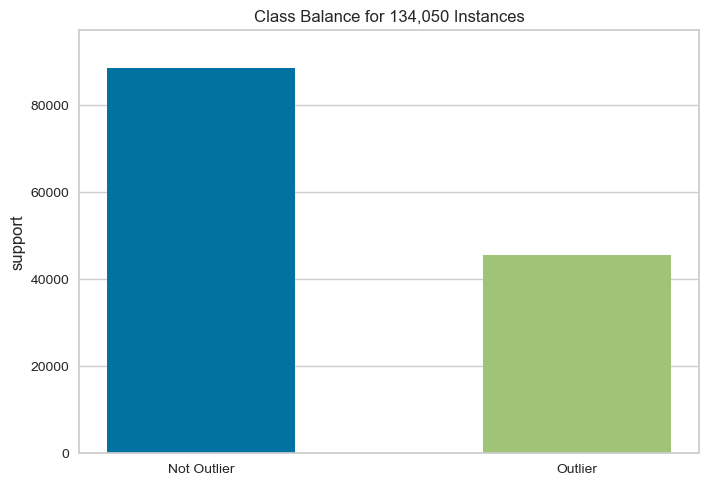

<Axes: title={'center': 'Class Balance for 134,050 Instances'}, ylabel='support'>

In [28]:
# Getting features for test and train 
labels = ["Not Outlier", "Outlier"]

visualizer = ClassBalance(labels=labels)
visualizer.fit(warm_states['Is_Outlier'])

# Show the visualizer
visualizer.show()

In [29]:
#your code here
seed=11
X = warm_states[warm_states.columns.difference(['Is_Outlier'])]
y = warm_states['Is_Outlier']

# --- Splitting into train/test (75-25 ratio, random state = seed)----------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

print(y_test)


159917    0.0
111321    0.0
94295     0.0
211430    1.0
128254    0.0
         ... 
247109    0.0
132069    0.0
347042    0.0
485258    1.0
63303     0.0
Name: Is_Outlier, Length: 33513, dtype: float64


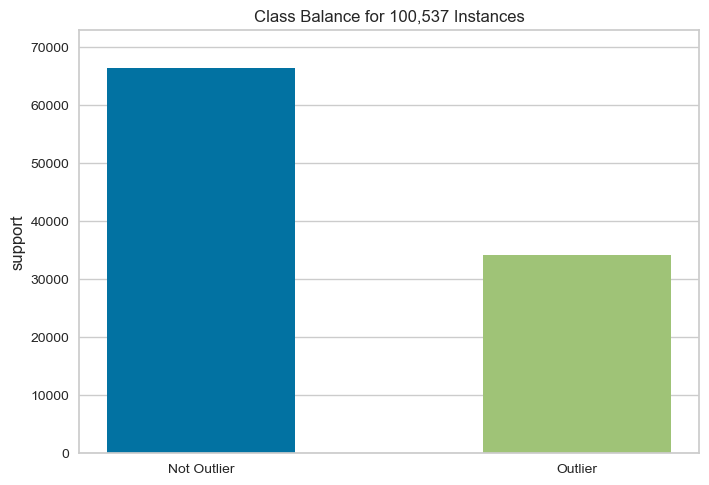

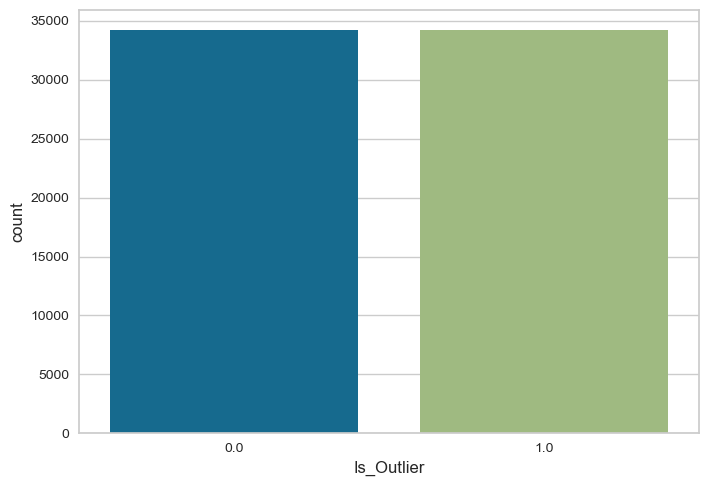

In [30]:
#We want to undersample
# your code here

visualizer = ClassBalance(labels = labels)
visualizer.fit(y_train)  
visualizer.show()   

# Undersample the majority class (no outliers)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Visualize class balance after undersampling
sns.countplot(x=y_train_resampled, tick_label=labels)
plt.show()

### 1. Naive Bayes

[[20008  2097]
 [10252  1156]]
              precision    recall  f1-score   support

 Not Outlier       0.66      0.91      0.76     22105
     Outlier       0.36      0.10      0.16     11408

    accuracy                           0.63     33513
   macro avg       0.51      0.50      0.46     33513
weighted avg       0.56      0.63      0.56     33513



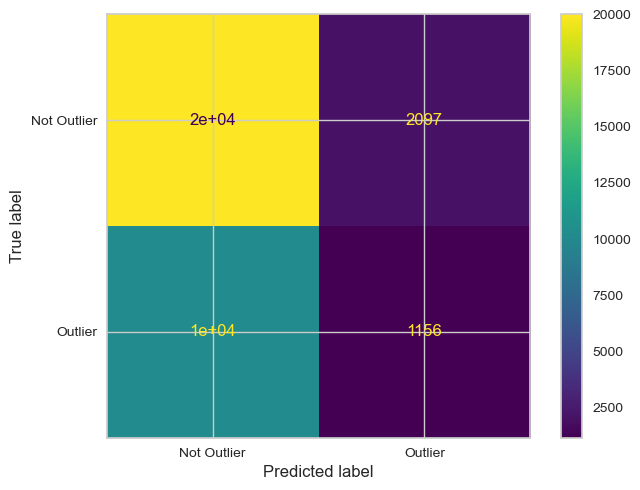

In [31]:
# your code here
modelNB = GaussianNB()

#Training the model
modelNB.fit(X_train_resampled, y_train_resampled)

#Getting predictions
y_train_pred_NB = modelNB.predict(X_train)
y_test_pred_NB = modelNB.predict(X_test)

#Print Confusion Matrix
print(confusion_matrix(y_test, y_test_pred_NB))

#Labels
labels = ["Not Outlier", "Outlier"]

#Print the classification report
print(classification_report(y_test, y_test_pred_NB, target_names=labels))

cm = confusion_matrix(y_test, y_test_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()


### 2. Random Forests Classifier

[[14357  7748]
 [ 3742  7666]]
              precision    recall  f1-score   support

 Not Outlier       0.79      0.65      0.71     22105
     Outlier       0.50      0.67      0.57     11408

    accuracy                           0.66     33513
   macro avg       0.65      0.66      0.64     33513
weighted avg       0.69      0.66      0.67     33513



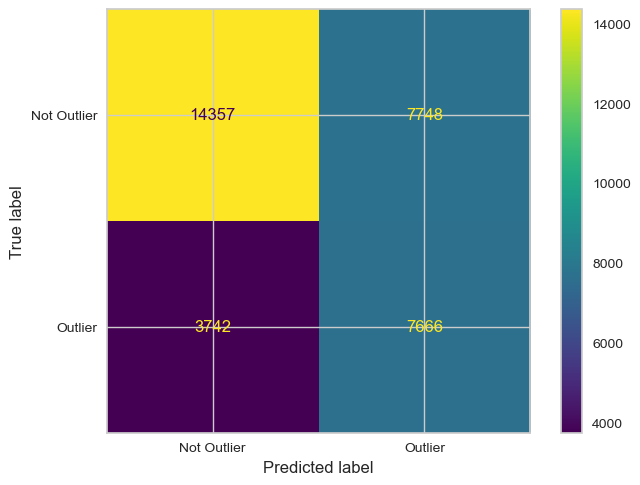

In [37]:
# your code here
model_rf = RandomForestClassifier()

#Fit the model
model_rf.fit(X_train_resampled, y_train_resampled)

#Evaluating the performance
y_pred_train_rf = model_rf.predict(X_train_resampled)
y_pred_test_rf = model_rf.predict(X_test)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_rf))

#Classification Report
print(classification_report(y_test, y_pred_test_rf, target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [49]:
# your code here

# Parameters
parameters = {'n_estimators': [50, 100, 200],'max_depth': [10, 15, 20, 30], 'max_features': ("sqrt", "log2")}

# Initialize
model_rfc_grid_search = GridSearchCV(model_rf, param_grid=parameters, cv=5, scoring='precision_micro')

# Train
model_rfc_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_rfc_grid_search.best_params_)

{'max_depth': 20, 'n_estimators': 200}


In [50]:
# your code here
rfc_best = RandomForestClassifier(max_depth=30, max_features= 'log2', n_estimators=200)

#Fit the model
rfc_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_rfc_best = rfc_best.predict(X_train_resampled)
y_pred_test_rfc_best = rfc_best.predict(X_test)

#Confusion Matrix
print(confusion_matrix(y_test, y_pred_test_rfc_best))

#Classification Report
print(classification_report(y_test, y_pred_test_rfc_best, target_names=labels))

[[14191  7914]
 [ 3619  7789]]
              precision    recall  f1-score   support

 Not Outlier       0.80      0.64      0.71     22105
     Outlier       0.50      0.68      0.57     11408

    accuracy                           0.66     33513
   macro avg       0.65      0.66      0.64     33513
weighted avg       0.69      0.66      0.66     33513



[[12984  9121]
 [ 3913  7495]]
              precision    recall  f1-score   support

 Not Outlier       0.77      0.59      0.67     22105
     Outlier       0.45      0.66      0.53     11408

    accuracy                           0.61     33513
   macro avg       0.61      0.62      0.60     33513
weighted avg       0.66      0.61      0.62     33513



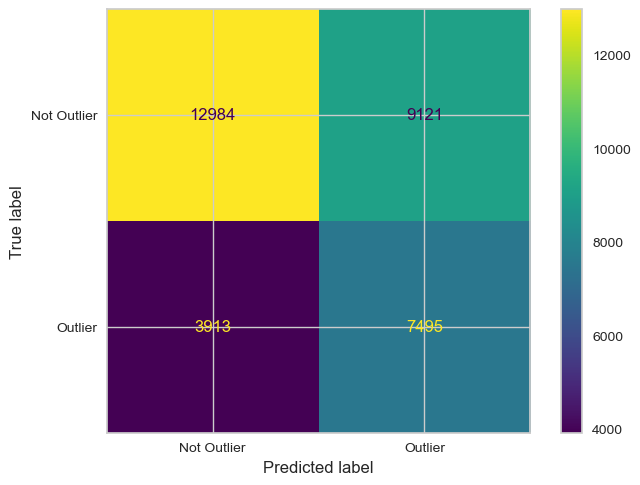

In [33]:
model_abc = AdaBoostClassifier()

#Fit the model
model_abc.fit(X_train_resampled, y_train_resampled)

#Predictions
y_pred_train_abc = model_abc.predict(X_train_resampled)
y_pred_test_abc = model_abc.predict(X_test)

print(confusion_matrix(y_test, y_pred_test_abc ))

#Classification report
print(classification_report(y_test, y_pred_test_abc , target_names=labels))

cm = confusion_matrix(y_test, y_pred_test_abc )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

[[13722  8383]
 [ 4025  7383]]
              precision    recall  f1-score   support

 Not Outlier       0.77      0.62      0.69     22105
     Outlier       0.47      0.65      0.54     11408

    accuracy                           0.63     33513
   macro avg       0.62      0.63      0.62     33513
weighted avg       0.67      0.63      0.64     33513



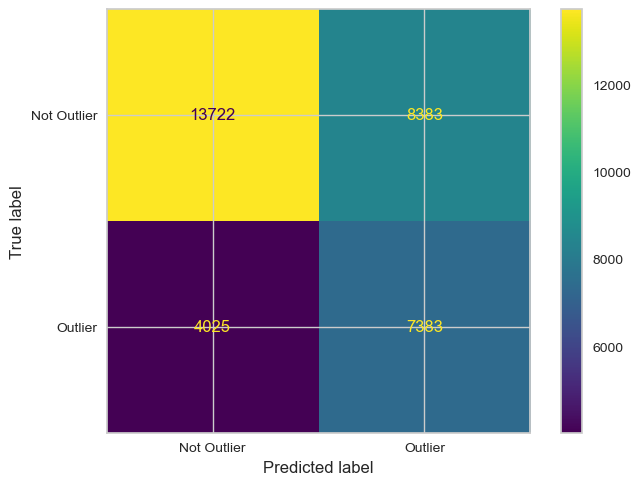

In [40]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create the XGBoost classifier
model_xgb = XGBClassifier()

# Fit the model
model_xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_train_xgb = model_xgb.predict(X_train_resampled)
y_pred_test_xgb = model_xgb.predict(X_test)

# Confusion matrix
print(confusion_matrix(y_test, y_pred_test_xgb))

# Classification report
print(classification_report(y_test, y_pred_test_xgb, target_names=labels))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

Parameters we would want to use since XGBooster gives higher accuracy is: 
scale_pos_weight: since our data is locating outliers, we would want to set scale_pos_weight to a value greater than 1 can give more importance to the minority class (outliers), which in turn would help the model to better capture their patterns
objective: 'binary:logistic', since we want to detect outliers, we are thinking of using an objective function that penalizes errors differently for outliers and normal instances
max_depth/min_child_weight: since we want to capture outliers, we want something that can lead to deeper and more complex trees, which may better capture the patterns of outliers

In [53]:
# Define the XGBoost classifier with the chosen parameters
model_xgb = XGBClassifier()

parameters = {
    'objective': ['binary:logistic'],  
    'scale_pos_weight': [2, 5, 7, 10],  
    'max_depth': [2, 6, 10, 15],
    'min_child_weight': [1, 3, 5, 7],  
    'n_estimators': [50, 100, 200]
}
# Initialize
model_xgb_grid_search = GridSearchCV(model_xgb, param_grid=parameters, cv=5, scoring='precision_micro')

# Train
model_xgb_grid_search.fit(X_train_resampled, y_train_resampled)

## Step 4: Print the best parameters
print(model_xgb_grid_search.best_params_)


In [ ]:
# your code here
xgb_best = XGBClassifier()

#Fit the model
xgb_best.fit(X_train_resampled, y_train_resampled)

#Evaluate the model, Predictions
y_pred_train_xgb_best = xgb_best.predict(X_train_resampled)
y_pred_test_xgb_best = xgb_best.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test_xgb_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()